# 2D Ising Model, Tensor RG, Finite-Size Scaling

In [1]:
import numpy as np
import pyuni10 as uni10
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
Kc = np.log(1+np.sqrt(2))/2
Tc = 2/np.log(1+np.sqrt(2))
A0 = 8*Kc*Kc/np.pi

def mat_W(beta, h):
    W = np.array([[np.exp(+beta+beta*h), np.exp(-beta)],
                  [np.exp(-beta), np.exp(+beta-beta*h)]])
    return W

def mat_M0(beta):
    M = np.array([[np.sqrt(np.cosh(beta)), np.sqrt(np.sinh(beta))],
                  [np.sqrt(np.cosh(beta)), -np.sqrt(np.sinh(beta))]])
    return M

def mat_M(beta, h):
    W = mat_W(beta, h)
    U, S, Vd = np.linalg.svd(W)
    if U[0, 0] < 0 :
        U = -U
        Vd = -Vd
    M = U @ np.diag( np.sqrt(S) )
    return M

def mat_T(beta, h):
    T = np.zeros((2,2,2,2))
    M = mat_M(beta, h)
    for i in range(1+1):
        for j in range(1+1):
            for k in range(1+1):
                for l in range(1+1):
                    T[i,j,k,l] = M[0,i]*M[0,j]*M[0,k]*M[0,l]+M[1,i]*M[1,j]*M[1,k]*M[1,l]
    T = T.reshape((4,4))
    return T

def delta_M():
    delta = np.zeros((4, 4))
    delta[0, 0] = 1.0
    delta[3, 3] = 1.0
    return delta

def Sz_M():
    Sz = np.zeros((4, 4))
    Sz[0, 0] = 1.0
    Sz[3, 3] = -1.0
    return Sz

In [3]:
# bonds
ket = uni10.Bond(uni10.BD_IN,2)
bra = uni10.Bond(uni10.BD_OUT,2)

# tensors (temperature and field independent)

# delta tensor
delta = uni10.UniTensorR([ket,ket,bra,bra])
delta.SetName('delta')
delta.PutBlock(delta_M())
delta.SetLabel([10,11,12,13])
# print(delta)

# Sz tensor
Sz = uni10.UniTensorR([ket,ket,bra,bra])
Sz.SetName('Sz')
Sz.PutBlock(Sz_M())
# print(Sz)

def bare_tensor(beta, h):
    # M & MT
    M = uni10.UniTensorR([ket, bra])
    M.SetName('M')
    M.PutBlock(mat_M(beta, h))
#     print(M)
    M.SetName('MT')
    MT = uni10.Transpose(M)
#     print(MT)

    # T 
    T = uni10.UniTensorR([ket,ket,bra,bra])
    T.SetName('T')
    net = uni10.Network("W2T.net")
    net.PutTensor("delta", delta)
    net.PutTensor("M",M)
    net.PutTensor("MT",MT)
    net.Launch(T)
#     print(T)

    # Tz
    Tz = uni10.UniTensorR([ket,ket,bra,bra])
    net = uni10.Network("W2T.net")
    net.PutTensor("delta", Sz)
    net.PutTensor("M",M)
    net.PutTensor("MT",MT)
    net.Launch(Tz)
    Tz.SetName('Tz')
#     print(Tz)
    return T, Tz

In [4]:
def exact(beta):
    Z = 2*np.exp(8*beta)+12+2*np.exp(-8*beta)
    F = -np.log(Z)/beta
    E = -(2*8*np.exp(8*beta)+2*(-8)*np.exp(-8*beta))/Z
    E_sqr = (2*64*np.exp(8*beta) +2*64*np.exp(-8*beta))/Z
    C = (E_sqr-E*E)*(beta*beta)
    M_abs = (2*4*np.exp(8*beta)+8*2)/Z
    M_sqr = (2*16*np.exp(8*beta)+8*4)/Z
    chi_p = (M_sqr-M_abs*M_abs)*beta
    
    return Z, F, E, E_sqr, C, M_abs, M_sqr, chi_p

In [5]:
def contract_4x4(T11, T12, T21, T22):
    net = uni10.Network("trace.net")
    s = uni10.UniTensorR()
    net.PutTensor('T11',T11)
    net.PutTensor('T12',T12)
    net.PutTensor('T21',T21)
    net.PutTensor('T22',T22)
    net.Launch(s)
    s = s.GetBlock(0)[0,0]
    return s

T, Tz = bare_tensor(2.0, 0.0)
Z = contract_4x4(T, T, T, T)
SzSz = contract_4x4(Tz, Tz, T, T)/Z
m = contract_4x4(Tz, T, T, T)/Z
print(SzSz)
print(m)

0.9999993247893827
2.7090812234241297e-15


Text(0, 0.5, '$C/N$')

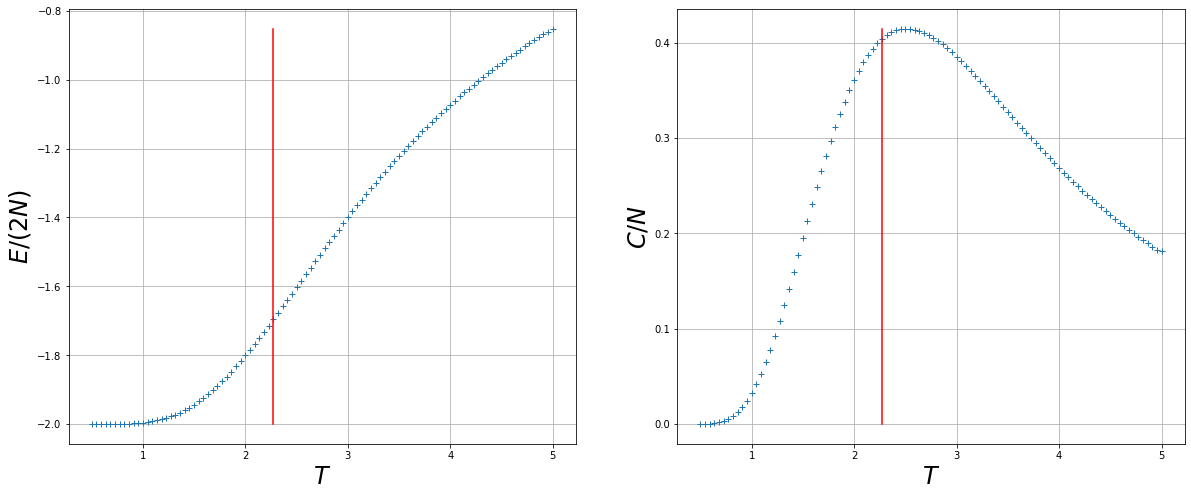

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

Temp = np.linspace(0.5, 5, 100)
beta = 1.0/Temp


h = 0
Z = np.zeros_like(beta)
SzSz = np.zeros_like(beta)

for i in range(beta.size):
    T, Tz = bare_tensor(beta[i], h)
    Z[i] = contract_4x4(T, T, T, T)
    SzSz[i] = contract_4x4(Tz, Tz, T, T)
 
N = 4 
E_N = -2*SzSz/Z # energy per site = 2 * energy per bond
C_N = np.gradient(E_N, Temp)


axes[0].plot(Temp, E_N, '+')
axes[0].plot([Tc, Tc], [np.min(E_N),np.max(E_N)], 'r')
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/(2N)$', fontsize=24)

axes[1].plot(Temp, C_N, '+')
axes[1].plot([Tc, Tc], [np.min(C_N),np.max(C_N)], 'r')
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$C/N$', fontsize=24)

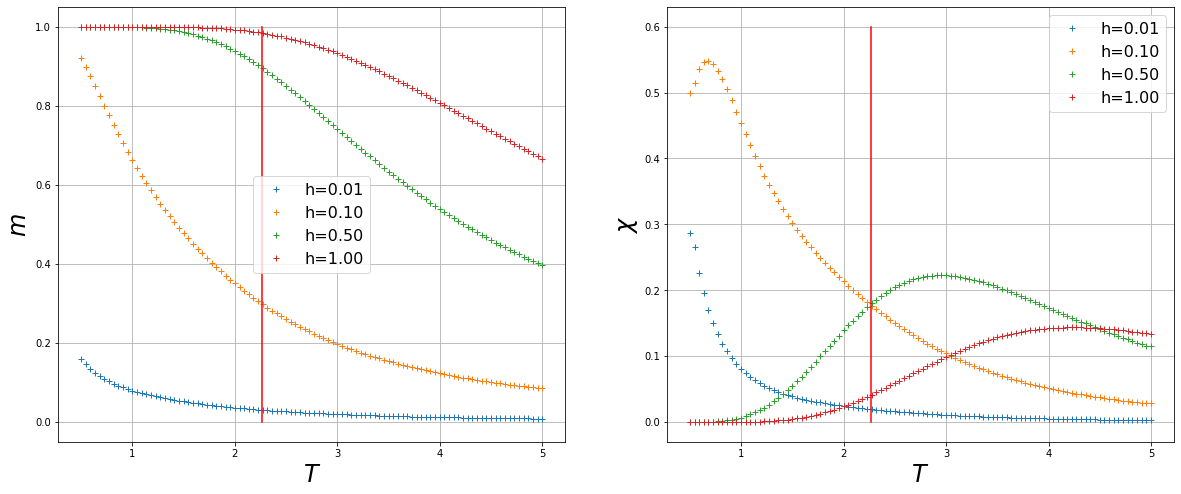

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

Temp = np.linspace(0.5, 5, 100)
beta = 1.0/Temp
Tc = 2/np.log(1+np.sqrt(2))

# h = 0.5
for h in (0.01,0.1, 0.5, 1):
    Z = np.zeros_like(beta)
    m = np.zeros_like(beta)

    for i in range(beta.size):
        T, Tz = bare_tensor(beta[i], h)
        Z[i] = contract_4x4(T, T, T, T)
        m[i] = contract_4x4(Tz, T, T, T)

    N = 4 
    m = m/Z
    chi = -np.gradient(m, Temp)
    axes[0].plot(Temp, m, '+', label='h={:.2f}'.format(h))
    axes[1].plot(Temp, chi, '+', label='h={:.2f}'.format(h))

axes[0].plot([Tc, Tc], [0, 1], 'r')
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$m$', fontsize=24)
axes[0].legend(fontsize=16)

axes[1].plot([Tc, Tc], [0,0.6], 'r')
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$\chi$', fontsize=24)
axes[1].legend(fontsize=16)

## TRG

In [8]:
# decompose a rank-4 tensor T into two rank-3 tensor S
# current version assume all legs of T have the same dimension
def T2LURD(T, D_cut):
    # S_LU and S_RD
    TM = T.GetBlock()
    D_cut = min(D_cut, TM.shape[0])
    U,Sigma,Vd = np.linalg.svd(TM)
    
    U_cut = U[:,:D_cut]
    Sigma_cut = Sigma[:D_cut]
    Vd_cut = Vd[:D_cut,:]

    bra = uni10.Bond(uni10.BD_OUT, D_cut)
    ket = uni10.Bond(uni10.BD_IN, D_cut)
 
    S_LU = uni10.UniTensorR([T.bond(0), T.bond(1), bra])
    S_LU.SetLabel([T.label(0),T.label(1),10])
    S_LU.PutBlock( U_cut @ np.diag(np.sqrt(Sigma_cut)))
    
    S_RD = uni10.UniTensorR([ket, T.bond(2), T.bond(3)])
    S_RD.SetLabel([10,T.label(2),T.label(3)])
    S_RD.PutBlock( np.diag(np.sqrt(Sigma_cut)) @ Vd_cut)   

    diff = uni10.Contract(S_LU, S_RD)-T
    return S_LU, S_RD

def T2LDRU(T, D_cut):
    # S_LD and S_RU
    # permute legs of T before SVD
    TP = uni10.UniTensorR(T)
    uni10.Permute(TP, [T.label(1),T.label(3),T.label(0),T.label(2)], 2)
    TM = TP.GetBlock()
    D_cut = min(D_cut, TM.shape[0])    
    U,Sigma,Vd = np.linalg.svd(TM)
    
    U_cut = U[:,:D_cut]
    Sigma_cut = Sigma[:D_cut]
    Vd_cut = Vd[:D_cut,:]

    bra = uni10.Bond(uni10.BD_OUT, D_cut)
    ket = uni10.Bond(uni10.BD_IN, D_cut)
 
    S_LD = uni10.UniTensorR([TP.bond(0), TP.bond(1), bra])
    S_LD.SetLabel([TP.label(0),TP.label(1),10])
    S_LD.PutBlock( U_cut @ np.diag(np.sqrt(Sigma_cut)))
    
    S_RU = uni10.UniTensorR([ket, TP.bond(2), TP.bond(3)])
    S_RU.SetLabel([10,TP.label(2),TP.label(3)])
    S_RU.PutBlock( np.diag(np.sqrt(Sigma_cut)) @ Vd_cut)    
    
    # permute legs of S    
    diff = uni10.Contract(S_LD, S_RU)-TP
    return S_LD, S_RU

# T = uni10.UniTensorR([ket, ket, bra, bra])
# T.SetName('T')
# T.SetRawElem(np.array(range(16)))
# S_LD, S_RU = T2LDRU(T, 4)

# contract four S tensors into a renormalized T tensor
def SSSS2T(S_RD, S_LD, S_RU, S_LU):
    T = uni10.UniTensorR([S_RD.bond(0),S_RU.bond(0),S_LD.bond(2),S_LU.bond(2)])
    net = uni10.Network('SSSS2T.net')
    net.PutTensor('S_RD', S_RD)
    net.PutTensor('S_LD', S_LD)
    net.PutTensor('S_RU', S_RU)
    net.PutTensor('S_LU', S_LU)
    net.Launch(T)
    return T

def half_RG(T, T11, T12, T21, T22, Dcut):        
    # first-half
    S_LD, S_RU = T2LDRU(T, Dcut)
    S_LU, S_RD = T2LURD(T, Dcut)
    
    # impurity tensors
    S11_LD, S11_RU = T2LDRU(T11, Dcut)
    S22_LD, S22_RU = T2LDRU(T22, Dcut)
    S12_LU, S12_RD = T2LURD(T12, Dcut)
    S21_LU, S21_RD = T2LURD(T21, Dcut)

    # RG of T
    TT = SSSS2T(S_RD, S_LD, S_RU, S_LU)

    # RG of T11
    TT11 = SSSS2T(S_RD, S11_LD, S_RU, S21_LU)
    TT22 = SSSS2T(S12_RD, S_LD, S22_RU, S_LU)
    TT12 = SSSS2T(S_RD, S_LD, S11_RU, S12_LU)
    TT21 = SSSS2T(S21_RD, S22_LD, S_RU, S_LU)
    
    # rescale
    Tmax = np.max(TT.GetBlock())
    TT = (1/Tmax)*TT
    TT11 = (1/Tmax)*TT11  
    TT12 = (1/Tmax)*TT12
    TT21 = (1/Tmax)*TT21
    TT22 = (1/Tmax)*TT22
    
    return TT, TT11, TT12, TT21, TT22

## Finite-Size Scaling

### Energy and specific heat

In [9]:
E = {}
C = {}

In [10]:
h = 0
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(1, 4, 50)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
SzSz = np.zeros((beta.size, NSize))
m = np.zeros((beta.size, NSize))

# Dcut = 2
# Dcut = 4
# Dcut = 8
# Dcut = 16
for D in [2,4,8,16]:
    for b in range(beta.size):
        T, Tz = bare_tensor(beta[b], h)
        T11 = Tz
        T12 = Tz
        T21 = T
        T22 = T

        for s in range(NSize):
            Z[b, s] = contract_4x4(T, T, T, T)
            SzSz[b, s] = contract_4x4(T11, T12, T21, T22)

            TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, D)
            T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, D)

    E_N = -2*SzSz/Z # energy per site = 2 * energy per bond
    E[D] = E_N
    # E['D2'] = E_N
    # E['D4'] = E_N
    # E['D8'] = E_N
    # E['D16'] = E_N

Text(0, 0.5, '$C/N$')

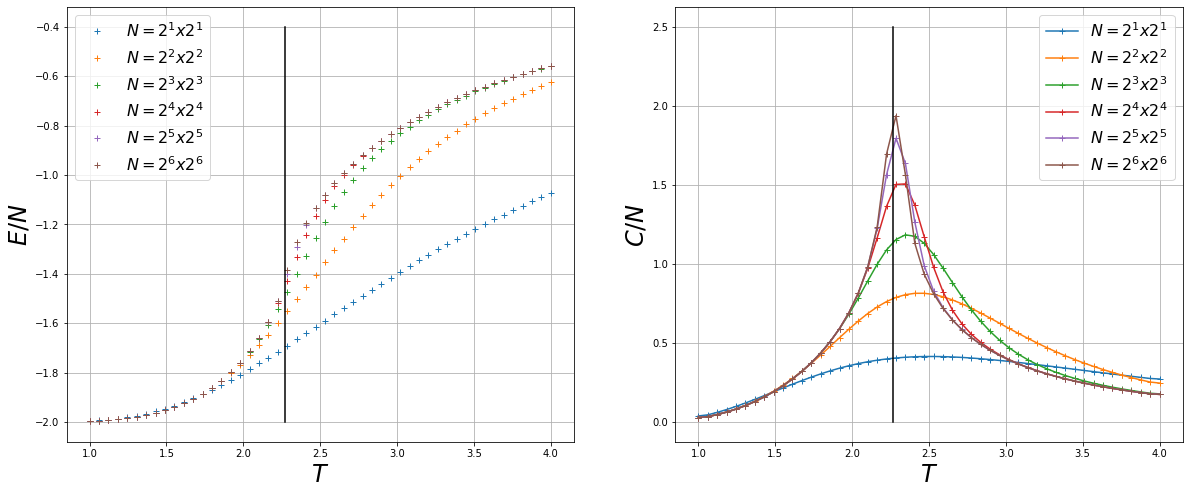

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

for s in range(NSize):
    axes[0].plot(Temp, E_N[:,s], '+', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))
    axes[1].plot(Temp, np.gradient(E_N[:,s],Temp), '+-', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))

    
axes[0].plot([Tc, Tc], [-2, -0.4], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/N$', fontsize=24)

axes[1].plot([Tc, Tc], [0,2.5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$C/N$', fontsize=24)

Text(0, 0.5, '$C/N$')

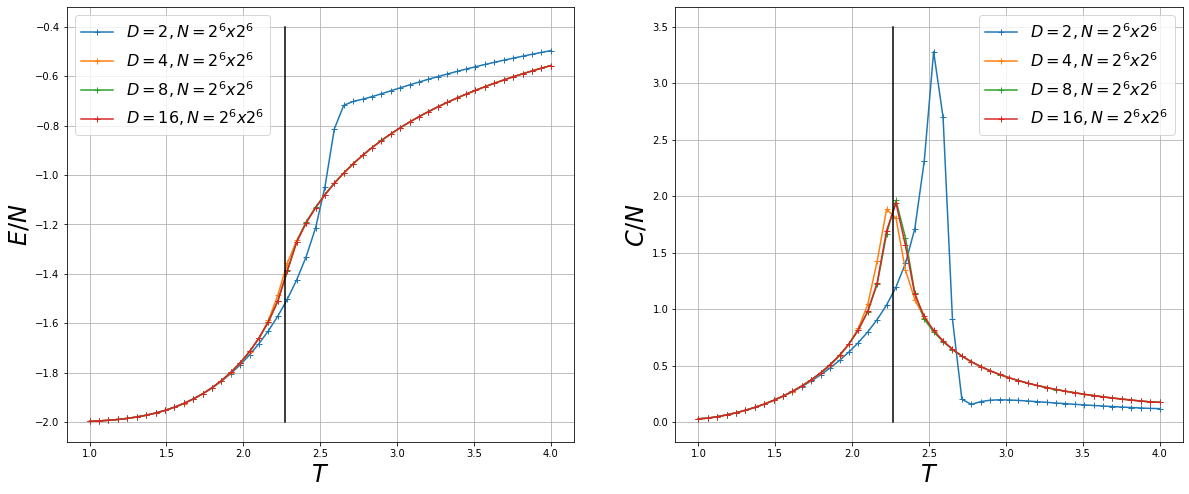

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

s = 5

for D in [2,4,8,16]:
    axes[0].plot(Temp, E[D][:,s], '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
    axes[1].plot(Temp, np.gradient(E[D][:,s],Temp), '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
    
axes[0].plot([Tc, Tc], [-2, -0.4], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/N$', fontsize=24)

axes[1].plot([Tc, Tc], [0,3.5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$C/N$', fontsize=24)

### Zoomed in

In [13]:
E_in = {}
C_in = {}

In [14]:
h = 0
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(2, 2.6, 100)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
SzSz = np.zeros((beta.size, NSize))
m = np.zeros((beta.size, NSize))

# Dcut = 2
# Dcut = 4
# Dcut = 8
# Dcut = 16
for D in [2,4,8,16]:
    for b in range(beta.size):
        T, Tz = bare_tensor(beta[b], h)
        T11 = Tz
        T12 = Tz
        T21 = T
        T22 = T

        for s in range(NSize):
            Z[b, s] = contract_4x4(T, T, T, T)
            SzSz[b, s] = contract_4x4(T11, T12, T21, T22)

            TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, D)
            T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, D)

    E_N = -2*SzSz/Z # energy per site = 2 * energy per bond
    E_in[D] = E_N
    # E['D2'] = E_N
    # E['D4'] = E_N
    # E['D8'] = E_N
    # E['D16'] = E_N

Text(0, 0.5, '$E/(2N)$')

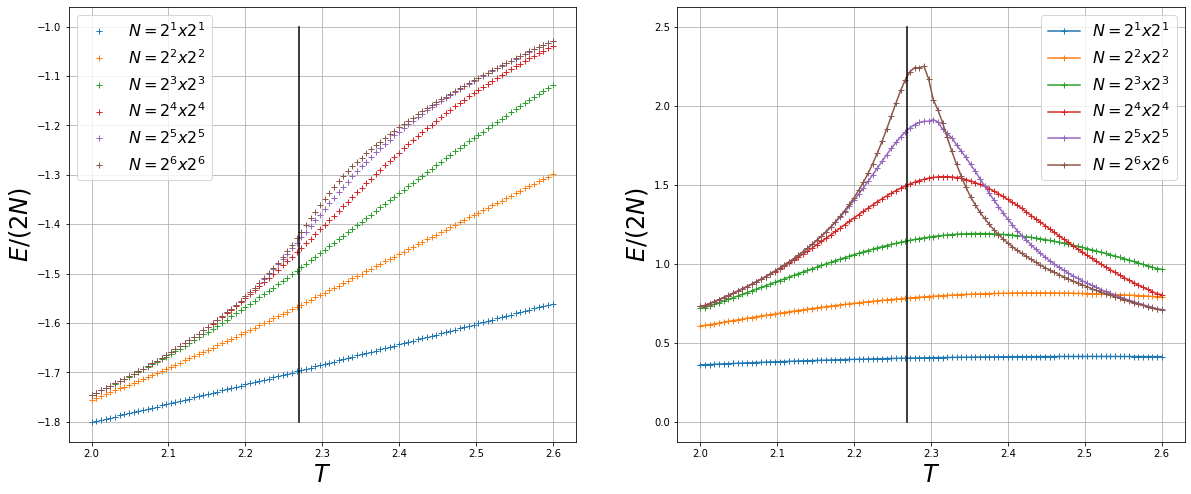

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

for s in range(NSize):
    axes[0].plot(Temp, E_N[:,s], '+', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))
    axes[1].plot(Temp, np.gradient(E_N[:,s],Temp), '+-', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))
    
axes[0].plot([Tc, Tc], [-1.8, -1], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/(2N)$', fontsize=24)

axes[1].plot([Tc, Tc], [0,2.5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$E/(2N)$', fontsize=24)

Text(0, 0.5, '$C/N$')

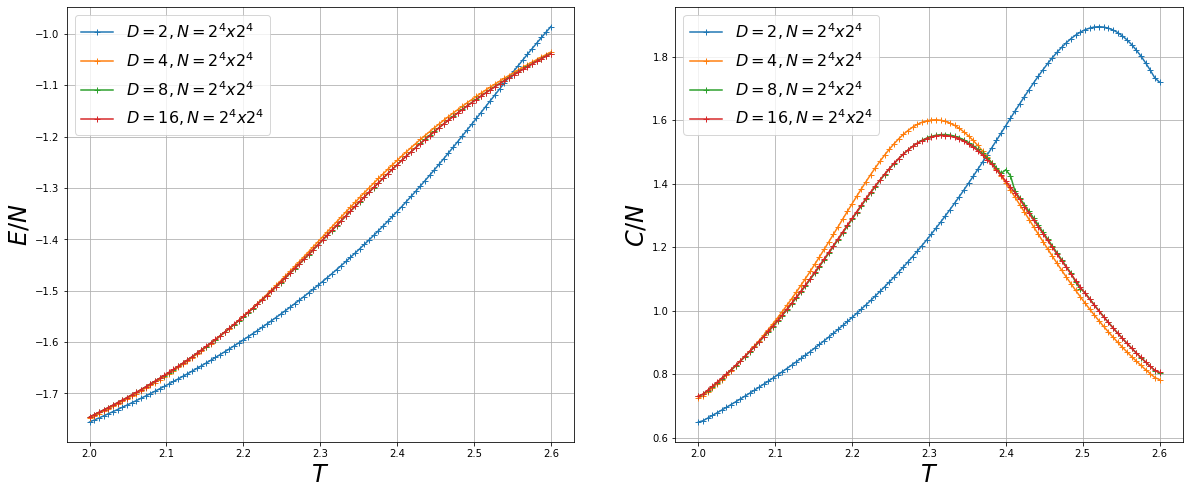

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

s = 3

for D in [2,4,8,16]:
    axes[0].plot(Temp, E_in[D][:,s], '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
    axes[1].plot(Temp, np.gradient(E_in[D][:,s],Temp), '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))


# axes[0].plot([Tc, Tc], [-1.8, -0.8], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/N$', fontsize=24)

# axes[1].plot([Tc, Tc], [0,5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$C/N$', fontsize=24)

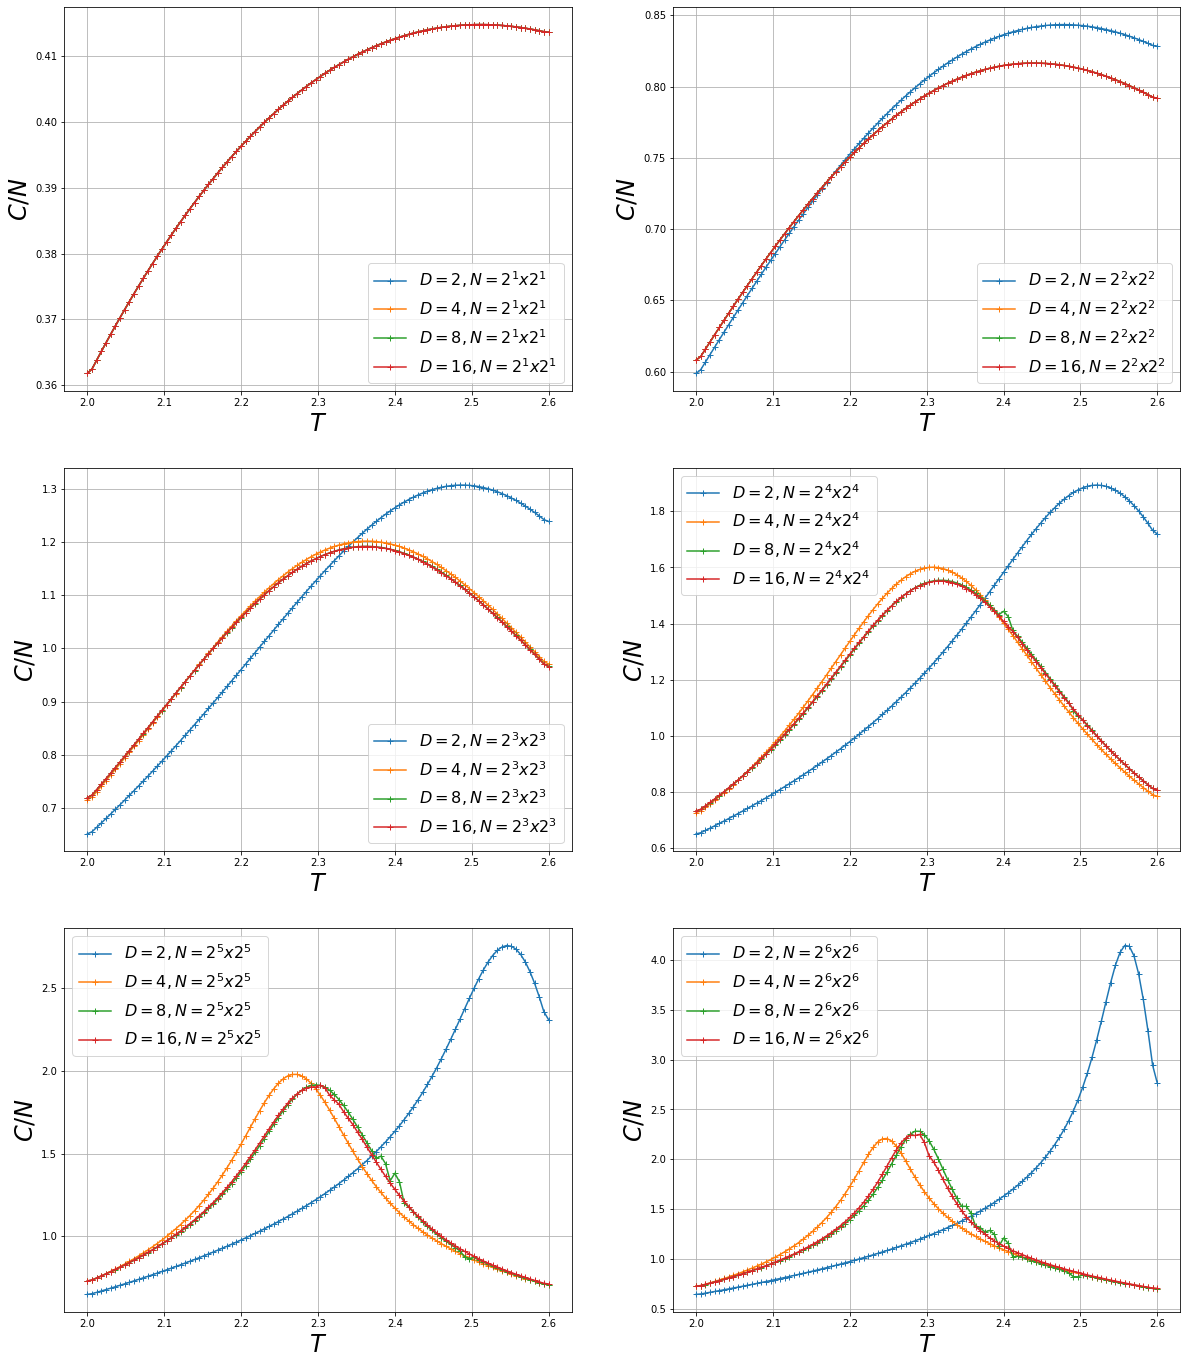

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10*2,8*3))

s = 5
for s in range(6):
    for D in [2,4,8,16]:
        axes[s//2, s%2].plot(Temp, np.gradient(E_in[D][:,s],Temp), '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
        axes[s//2, s%2].legend(fontsize=16)
        axes[s//2, s%2].grid()
        axes[s//2, s%2].set_xlabel(r'$T$', fontsize=24)
        axes[s//2, s%2].set_ylabel(r'$C/N$', fontsize=24)

axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
axes[2,0].grid()
axes[2,1].grid()

0.5286748554344679 0.07365809400457075
[2.28896174 1.39597937 1.41001458]


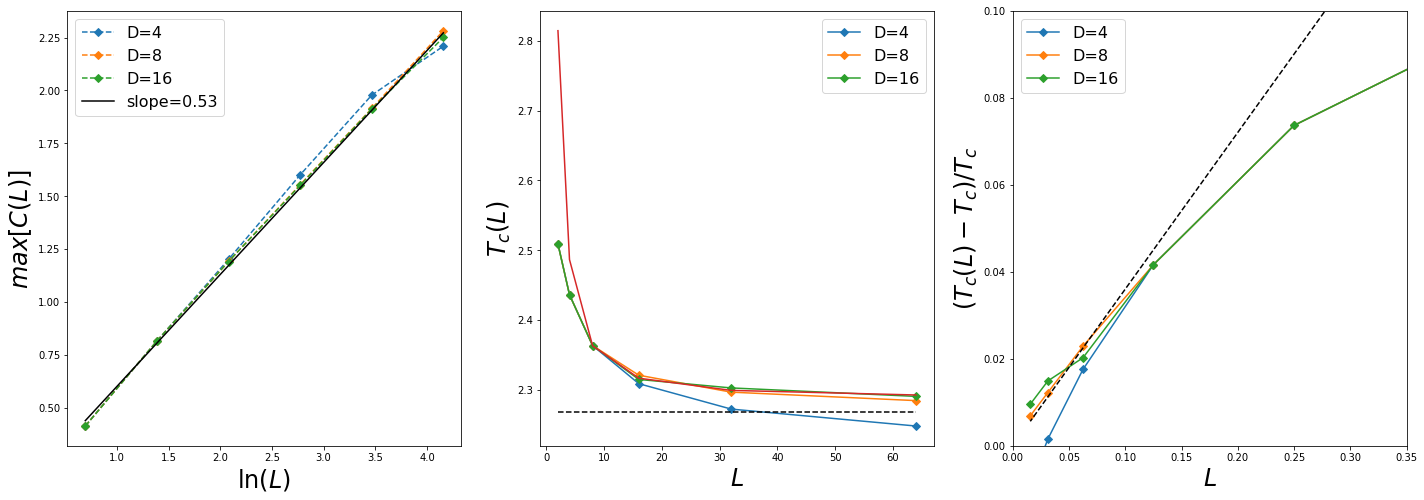

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8*3,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [4,8,16]:
    Tc_L = np.zeros(6)
    Cmax_L = np.zeros(6)

    for s in range(6):
        c = np.gradient(E_in[D][:,s],Temp)
        ic = np.argmax(c)
        Tc_L[s] = Temp[ic]
        Cmax_L[s] = c[ic]
    axes[0].plot(np.log(L), Cmax_L,'D--', label='D={}'.format(D))
    axes[1].plot(L, Tc_L,'D-', label='D={}'.format(D))
    axes[2].plot(1/L, (Tc_L-Tc)/Tc,'D-', label='D={}'.format(D))

m,b = np.polyfit(np.log(L), Cmax_L, 1)    
print(m,b) 
axes[0].plot(np.log(L), b+m*np.log(L), 'k', label='slope={:.2f}'.format(m))
axes[0].set_xlabel(r'$\ln(L)$',fontsize=24)
axes[0].set_ylabel(r'$max[C(L)]$',fontsize=24)
axes[0].legend(fontsize=16)

def func(x, a, b, c):
    return a+b/x**c
popt, pcov = curve_fit(func, L[2:], Tc_L[2:], p0=[Tc, 0.4, 1])
print(popt)

axes[1].plot(L, func(L, *popt), )

axes[1].plot([L[0],L[-1]],[Tc, Tc],'k--')
axes[1].set_xlabel(r'$L$',fontsize=24)
axes[1].set_ylabel(r'$T_c(L)$',fontsize=24)
axes[1].legend(fontsize=16)

x = np.linspace(1,1024)
axes[2].plot(1/L,0.36029/L,'k--')
axes[2].set_xlim([0,0.35])
axes[2].set_ylim([0,0.1])
axes[2].set_xlabel(r'$L$',fontsize=24)
axes[2].set_ylabel(r'$(T_c(L)-T_c)/T_c$',fontsize=24)
axes[2].legend(fontsize=16)

0.5286748554344679 0.07365809400457075


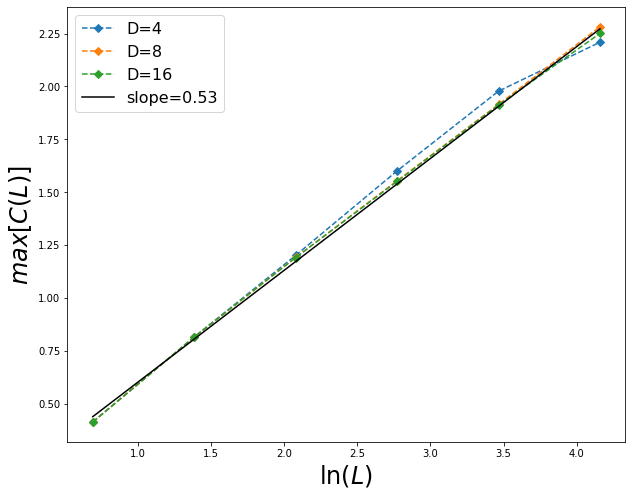

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [4,8,16]:
    Tc_L = np.zeros(6)
    Cmax_L = np.zeros(6)

    for s in range(6):
        c = np.gradient(E_in[D][:,s],Temp)
        ic = np.argmax(c)
        Tc_L[s] = Temp[ic]
        Cmax_L[s] = c[ic]
    axes.plot(np.log(L), Cmax_L,'D--', label='D={}'.format(D))

m,b = np.polyfit(np.log(L), Cmax_L, 1)    
print(m,b) 
axes.plot(np.log(L), b+m*np.log(L), 'k', label='slope={:.2f}'.format(m))
axes.set_xlabel(r'$\ln(L)$',fontsize=24)
axes.set_ylabel(r'$max[C(L)]$',fontsize=24)
axes.legend(fontsize=16)

0.5286748554344679 0.07365809400457075


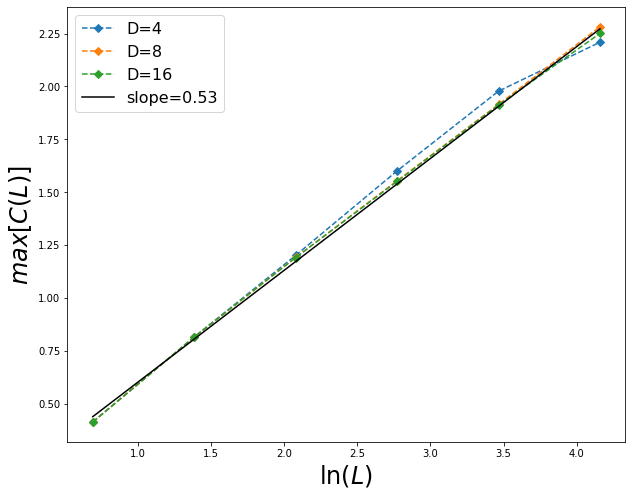

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [4,8,16]:
    Tc_L = np.zeros(6)
    Cmax_L = np.zeros(6)

    for s in range(6):
        c = np.gradient(E_in[D][:,s],Temp)
        ic = np.argmax(c)
        Tc_L[s] = Temp[ic]
        Cmax_L[s] = c[ic]
    axes.plot(np.log(L), Cmax_L,'D--', label='D={}'.format(D))

m,b = np.polyfit(np.log(L), Cmax_L, 1)    
print(m,b) 
axes.plot(np.log(L), b+m*np.log(L), 'k', label='slope={:.2f}'.format(m))
axes.set_xlabel(r'$\ln(L)$',fontsize=24)
axes.set_ylabel(r'$max[C(L)]$',fontsize=24)
axes.legend(fontsize=16)

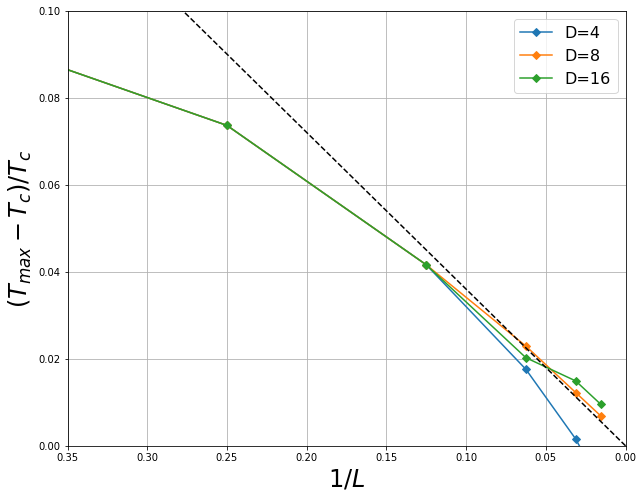

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [4,8,16]:
    Tc_L = np.zeros(6)
    Cmax_L = np.zeros(6)

    for s in range(6):
        c = np.gradient(E_in[D][:,s],Temp)
        ic = np.argmax(c)
        Tc_L[s] = Temp[ic]
        Cmax_L[s] = c[ic]
    axes.plot(1/L, (Tc_L-Tc)/Tc,'D-', label='D={}'.format(D))

x = np.linspace(0,0.35)
axes.plot(x,0.36029*x,'k--')
axes.set_xlim([0,0.35])
axes.set_ylim([0,0.1])
axes.set_xlabel(r'$1/L$',fontsize=24)
axes.set_ylabel(r'$(T_{max}-T_c)/T_c$',fontsize=24)
axes.legend(fontsize=16)
axes.invert_xaxis()
axes.grid()

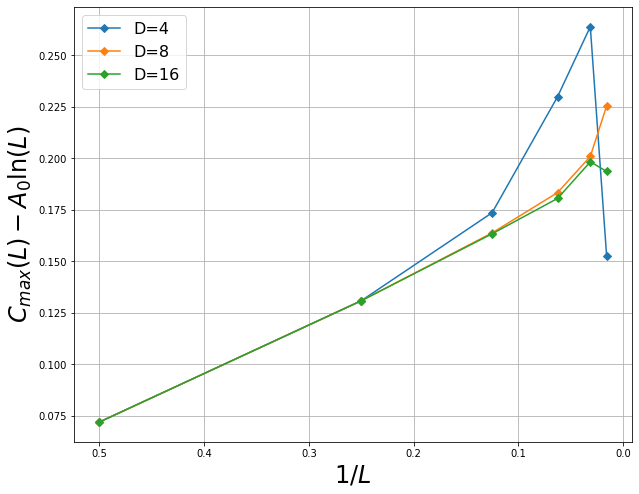

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [4,8,16]:
    Tc_L = np.zeros(6)
    Cmax_L = np.zeros(6)

    for s in range(6):
        c = np.gradient(E_in[D][:,s],Temp)
        ic = np.argmax(c)
        Tc_L[s] = Temp[ic]
        Cmax_L[s] = c[ic]
    axes.plot(1/L, Cmax_L-A0*np.log(L),'D-', label='D={}'.format(D))

axes.set_xlabel(r'$1/L$',fontsize=24)
axes.set_ylabel(r'$C_{max}(L)-A_0\ln(L)$',fontsize=24)
axes.legend(fontsize=16)
axes.invert_xaxis()
axes.grid()

## Magnetization and susceptibility

In [26]:
mag = {}
chi = {}

In [27]:
h = 0.001
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(1, 4, 50)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
# SzSz = np.zeros((beta.size, NSize))
m = np.zeros((beta.size, NSize))

for D in [2,4,8,16]:
    for b in range(beta.size):
        T, Tz = bare_tensor(beta[b], h)
        T11 = Tz
        T12 = T
        T21 = T
        T22 = T

        for s in range(NSize):
            Z[b, s] = contract_4x4(T, T, T, T)
            m[b, s] = contract_4x4(T11, T12, T21, T22)

            TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, D)
            T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, D)
            
    m = m/Z
    mag[D] = m

Text(0, 0.5, '$\\chi$')

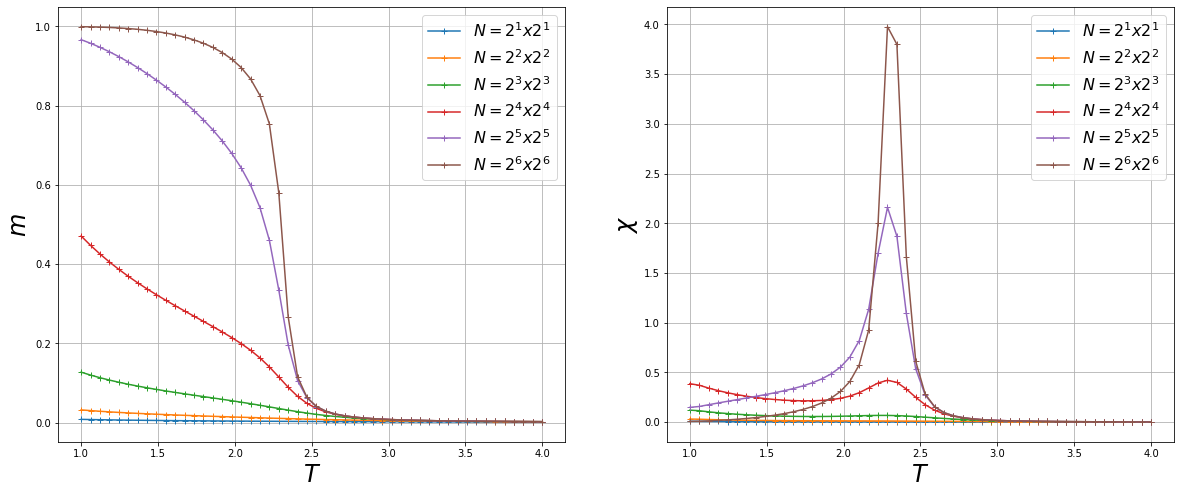

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

NSize = 6

for s in range(NSize):
    axes[0].plot(Temp, m[:,s], '+-', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))
    axes[1].plot(Temp, -np.gradient(m[:,s],Temp), '+-', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))

    
# axes[0].plot([Tc, Tc], [0,1], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$m$', fontsize=24)

# axes[1].plot([Tc, Tc], [0,2.5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$\chi$', fontsize=24)

Text(0, 0.5, '$C/N$')

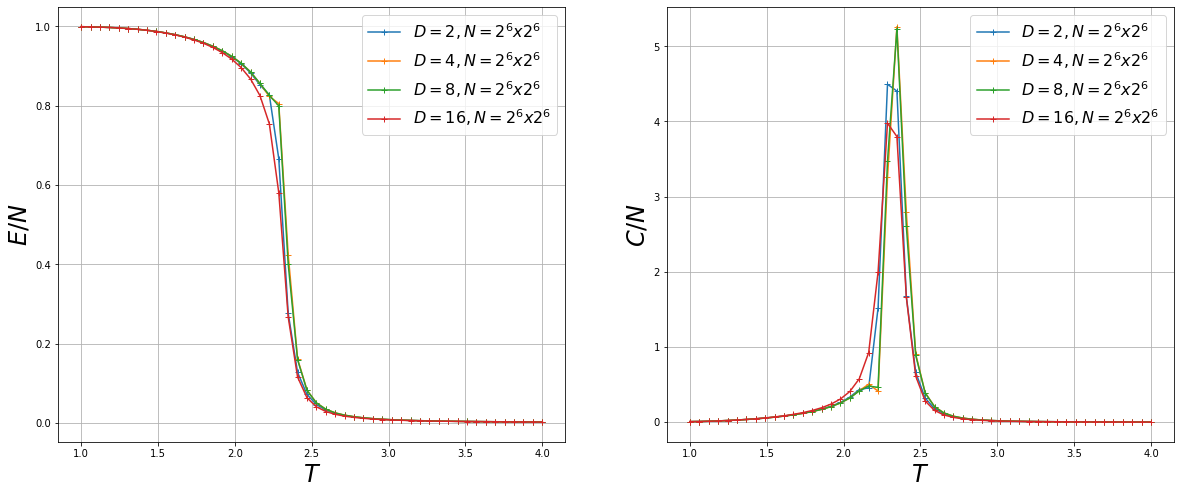

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

s = 5

for D in [2,4,8,16]:
    axes[0].plot(Temp, mag[D][:,s], '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
    axes[1].plot(Temp, -np.gradient(mag[D][:,s],Temp), '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))


# axes[0].plot([Tc, Tc], [-2, -0.4], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/N$', fontsize=24)

# axes[1].plot([Tc, Tc], [0,3.5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$C/N$', fontsize=24)

### Zoomed in

In [30]:
mag_in = {}
chi_in = {}

In [31]:
h = 0.001
Tc = 2/np.log(1+np.sqrt(2))

Temp = np.linspace(2, 2.6, 100)
beta = 1.0/Temp

NSize = 6

Z = np.zeros((beta.size, NSize))
# SzSz = np.zeros((beta.size, NSize))
m = np.zeros((beta.size, NSize))

for D in [2,4,8,16]:
    for b in range(beta.size):
        T, Tz = bare_tensor(beta[b], h)
        T11 = Tz
        T12 = T
        T21 = T
        T22 = T

        for s in range(NSize):
            Z[b, s] = contract_4x4(T, T, T, T)
            m[b, s] = contract_4x4(T11, T12, T21, T22)

            TT, TT11, TT12, TT21, TT22 = half_RG(T, T11, T12, T21, T22, D)
            T, T11, T12, T21, T22 = half_RG(TT, TT11, TT12, TT21, TT22, D)
            
    m = m/Z
    mag_in[D] = m

Text(0, 0.5, '$\\chi$')

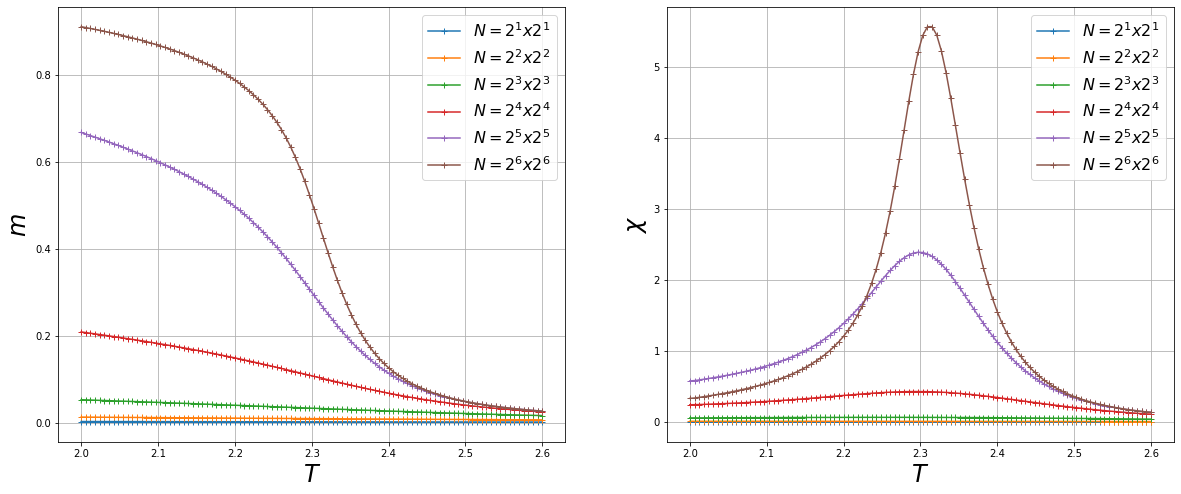

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

NSize = 6

for s in range(NSize):
    axes[0].plot(Temp, m[:,s], '+-', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))
    axes[1].plot(Temp, -np.gradient(m[:,s],Temp), '+-', label=r'$N=2^{}x2^{}$'.format(s+1,s+1))

    
# axes[0].plot([Tc, Tc], [0,1], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$m$', fontsize=24)

# axes[1].plot([Tc, Tc], [0,2.5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$\chi$', fontsize=24)

Text(0, 0.5, '$C/N$')

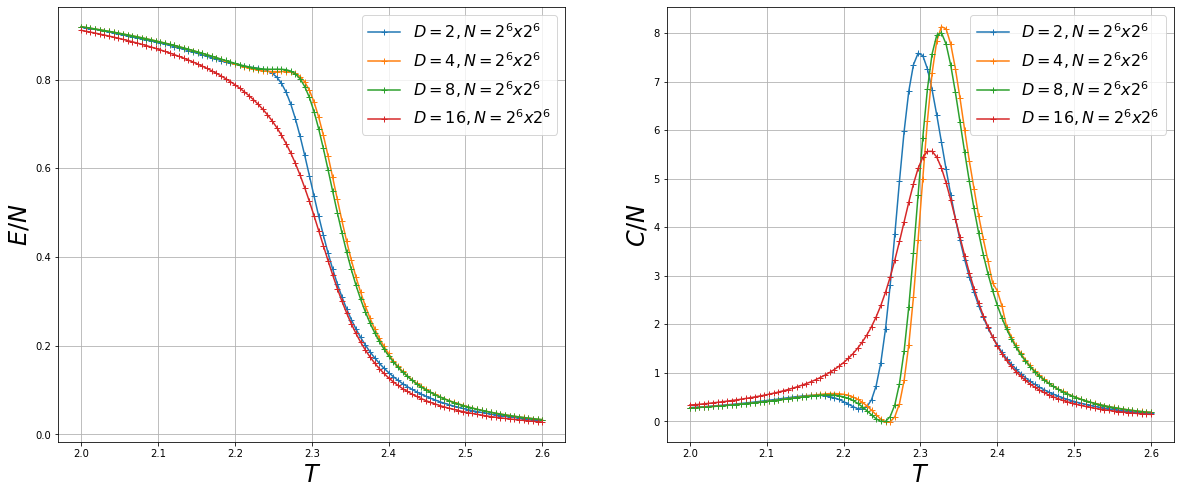

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10*2,8))

s = 5

for D in [2,4,8,16]:
    axes[0].plot(Temp, mag_in[D][:,s], '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
    axes[1].plot(Temp, -np.gradient(mag_in[D][:,s],Temp), '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))


# axes[0].plot([Tc, Tc], [-1.8, -0.8], 'k')
axes[0].legend(fontsize=16)
axes[0].grid()
axes[0].set_xlabel(r'$T$', fontsize=24)
axes[0].set_ylabel(r'$E/N$', fontsize=24)

# axes[1].plot([Tc, Tc], [0,5], 'k')
axes[1].legend(fontsize=16)
axes[1].grid()
axes[1].set_xlabel(r'$T$', fontsize=24)
axes[1].set_ylabel(r'$C/N$', fontsize=24)

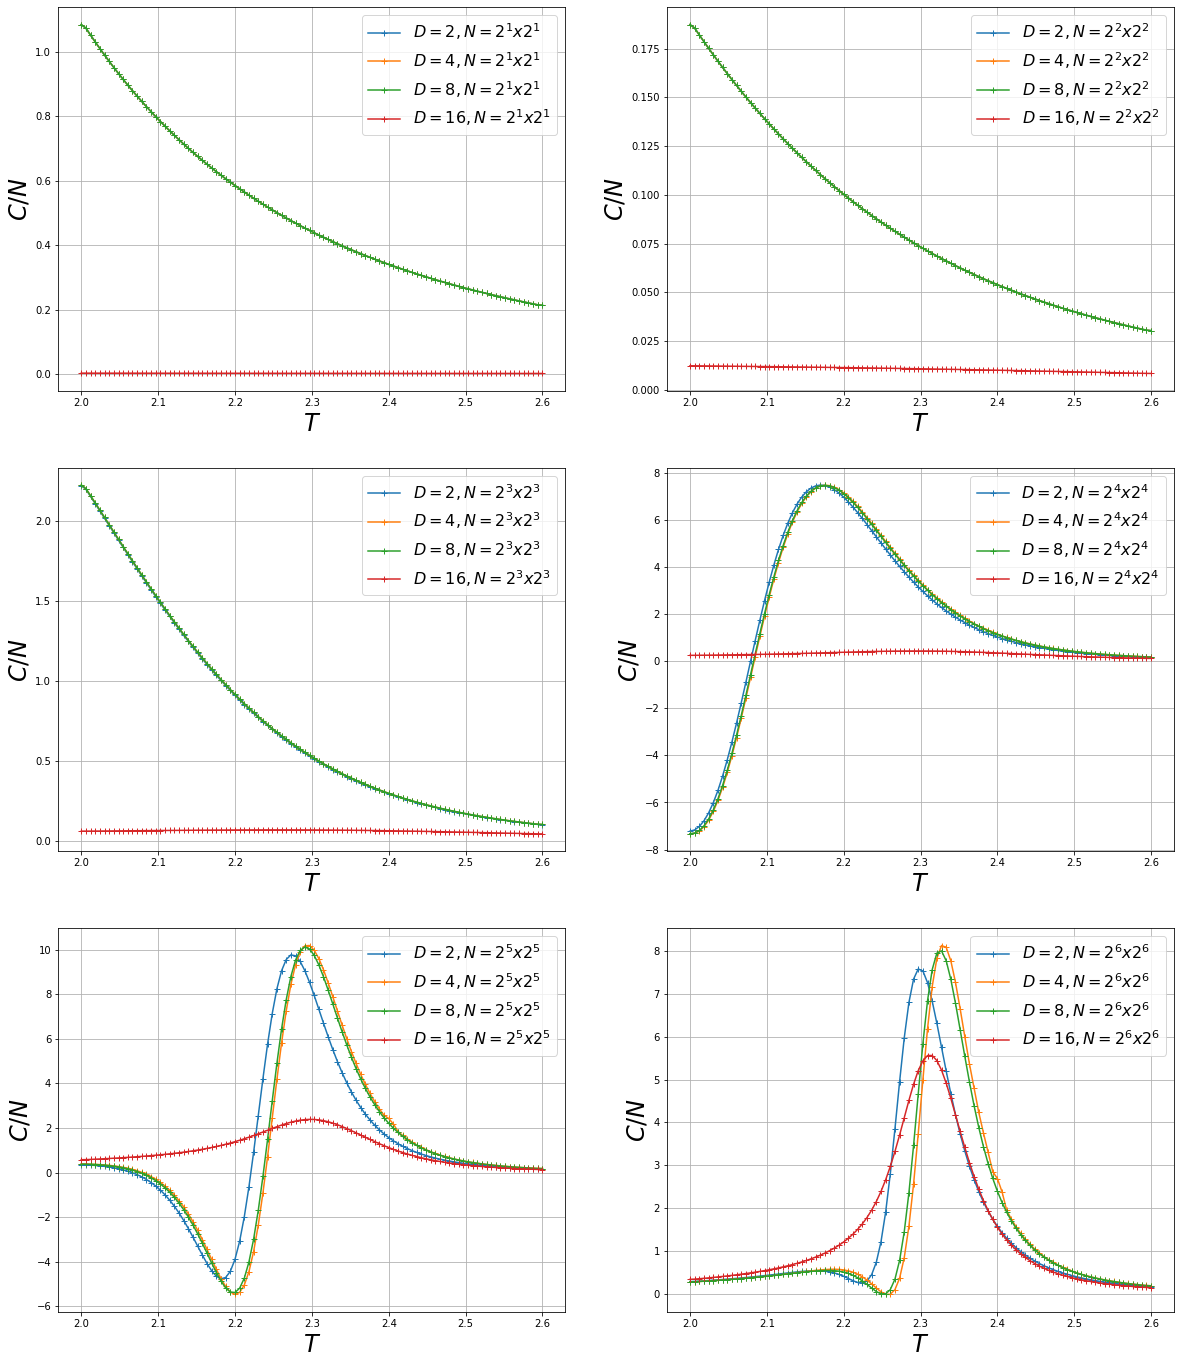

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10*2,8*3))

s = 5
for s in range(6):
    for D in [2,4,8,16]:
        axes[s//2, s%2].plot(Temp, -np.gradient(mag_in[D][:,s],Temp), '+-', label=r'$D={}, N=2^{}x2^{}$'.format(D,s+1,s+1))
        axes[s//2, s%2].legend(fontsize=16)
        axes[s//2, s%2].grid()
        axes[s//2, s%2].set_xlabel(r'$T$', fontsize=24)
        axes[s//2, s%2].set_ylabel(r'$C/N$', fontsize=24)

axes[0,0].grid()
axes[0,1].grid()
axes[1,0].grid()
axes[1,1].grid()
axes[2,0].grid()
axes[2,1].grid()

2.321898057902156 -7.526851367129077


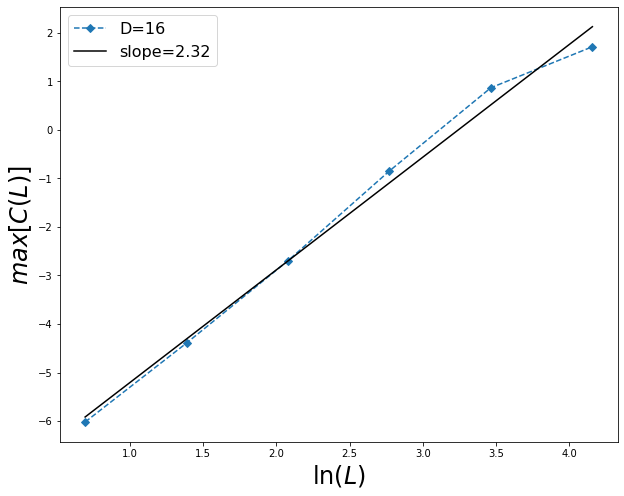

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [16]:
    Tc_L = np.zeros(6)
    chi_max_L = np.zeros(6)

    for s in range(6):
        chi = -np.gradient(mag_in[D][:,s],Temp)
        ic = np.argmax(chi)
        Tc_L[s] = Temp[ic]
        chi_max_L[s] = chi[ic]
    axes.plot(np.log(L), np.log(chi_max_L),'D--', label='D={}'.format(D))

m,b = np.polyfit(np.log(L), np.log(chi_max_L), 1)    
print(m,b) 
axes.plot(np.log(L), b+m*np.log(L), 'k', label='slope={:.2f}'.format(m))

axes.set_xlabel(r'$\ln(L)$',fontsize=24)
axes.set_ylabel(r'$max[C(L)]$',fontsize=24)
axes.legend(fontsize=16)

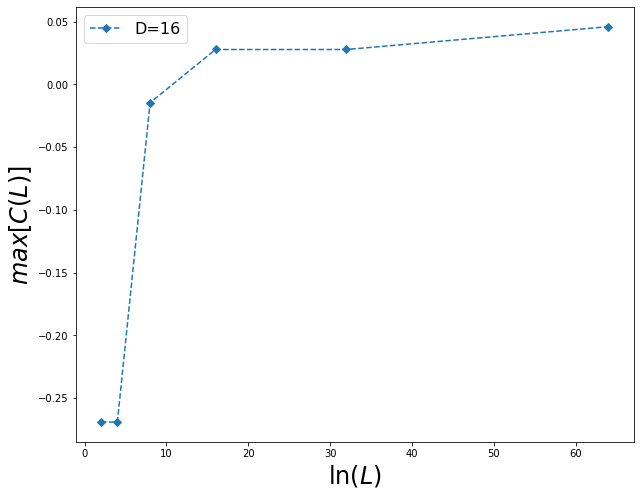

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

L = np.array([2.**(n+1) for n in range(NSize)])

for D in [16]:
    Tc_L = np.zeros(6)
    chi_max_L = np.zeros(6)

    for s in range(6):
        chi = -np.gradient(mag_in[D][:,s],Temp)
        ic = np.argmax(chi)
        Tc_L[s] = Temp[ic]
        chi_max_L[s] = chi[ic]
    axes.plot(L, Tc_L-Tc,'D--', label='D={}'.format(D))

# m,b = np.polyfit(np.log(L), np.log(chi_max_L), 1)    
# print(m,b) 
# axes.plot(np.log(L), b+m*np.log(L), 'k', label='slope={:.2f}'.format(m))

axes.set_xlabel(r'$\ln(L)$',fontsize=24)
axes.set_ylabel(r'$max[C(L)]$',fontsize=24)
axes.legend(fontsize=16)